# Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [24]:
def plot_cam_anoms(df, cam=None, dur="30Min", weekday=True,
                   get_results=False, titles=None):
    if weekday:
        tmp = df[df.index.weekday < 5].copy()
    else:
        tmp = df[df.index.weekday >= 5].copy()
        
    if cam != None:
        tmp = tmp[tmp.cam_id == cam][["count"]]
    else:
        tmp = tmp[["count"]]
        
    
    tmp["d"] = tmp.index.date
    tmp["t"] = map(lambda x: pd.datetime.combine(pd.datetime.today(), x), tmp.index.time)
    
    tmp = tmp.groupby(["d", "t"]).mean() \
                .unstack(level=0) \
                .resample(dur).mean() \
                .dropna(axis=1).T
    tmp.index = tmp.index.droplevel(0)
    
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10),
                                   gridspec_kw={"height_ratios": [2, 5]})
    tmp.T.plot(ax=ax1, legend=False, c="k", alpha=0.3, lw=0.8)
    tmp.mean().T.plot(ax=ax1, c="r", label="Mean")
    ax1.fill_between(tmp.T.index, 
                     tmp.mean().T + 2*tmp.std().values, 
                     tmp.mean().T - 2*tmp.std().values, 
                     alpha=0.2, color="k", label="2 Std Dev")
    ax1.set_xlabel("Time (H:M)", fontsize=13)
    ax1.set_ylabel("Pedestrian Count", fontsize=13)
    handles, labels = ax1.get_legend_handles_labels()
    handles = handles[-3:]
    ax1.legend(handles, ["Daily Pedestrian Count", "Mean", "2 Std. Dev."])
    ax1.tick_params(axis="both", which="both", labelsize=12)
    ax1.set_title("Pedestrian Count Time Series at Camera {}".format(cam), fontsize=16)
    
    im = ax2.imshow((tmp - tmp.mean()).values, cmap="viridis", aspect="auto")
    cbar = fig.colorbar(im, ax=ax2, orientation="horizontal", pad=0.1)
    cbar.ax.set_xlabel("Pedestrian Count")
    ax2.set_xticklabels(range(24))
    ax2.set_xticks(np.arange(-.5, 47.5, 2))
    ax2.grid(alpha=0.2)
    ax2.set_xlabel("Hour", fontsize=13)
    ax2.set_ylabel("Date", fontsize=13)
    ax2.set_yticks(range(len(tmp.index)))
    ax2.set_yticklabels(map(lambda x: x[0] + " " + x[1], 
                            zip(map(lambda x: x.strftime("%d-%m-%y"), tmp.index),
                            map(lambda x: x.strftime("%A")[:3], tmp.index))))
    ax2.tick_params(axis="x", which="both", labelsize=12)
    ax2.set_title("Pedestrian Count Difference From Mean at Camera {}".format(
            cam), fontsize=16)
    
    if titles != None:
        try:
            ax1.set_title(titles[0], fontsize=16)
            ax2.set_title(titles[1], fontsize=16)
        except:
            print "Passed titles are not list-like with len==2"
    else:
        ax1.set_title("Pedestrian Count Time Series at Camera {}" \
                      .format(cam), fontsize=16)
        ax2.set_title("Pedestrian Count Difference From Mean at Camera {}"\
                      .format(cam), fontsize=16)
        
    fig.tight_layout()
    
    if get_results:
        return tmp

# Load Data

In [3]:
df = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str, 
                        "count": int, "imtime": str}, parse_dates=["date"], 
                 infer_datetime_format=True, index_col="date")

print df.dtypes
df.head(2)

cam_id      int64
cam_dir    object
count       int64
imtime     object
dtype: object


,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [4]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


In [5]:
df = df.reset_index().merge(cams).set_index("date")[["cam_id", "count", "people", "boro"]]
df.head(2)

,cam_id,count,people,boro
date,,,,
2017-06-27 20:09:22,368,1,1.0,Manhattan
2017-06-27 20:10:39,368,1,1.0,Manhattan


# Anomaly Plots
## Choose a Camera

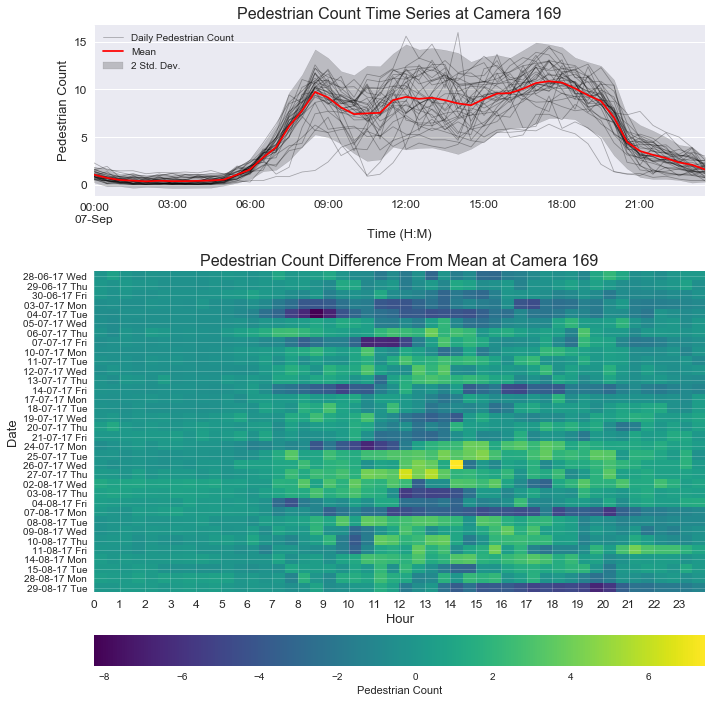

In [16]:
plot_cam_anoms(df, 169)

## Manhattan
### Weekday

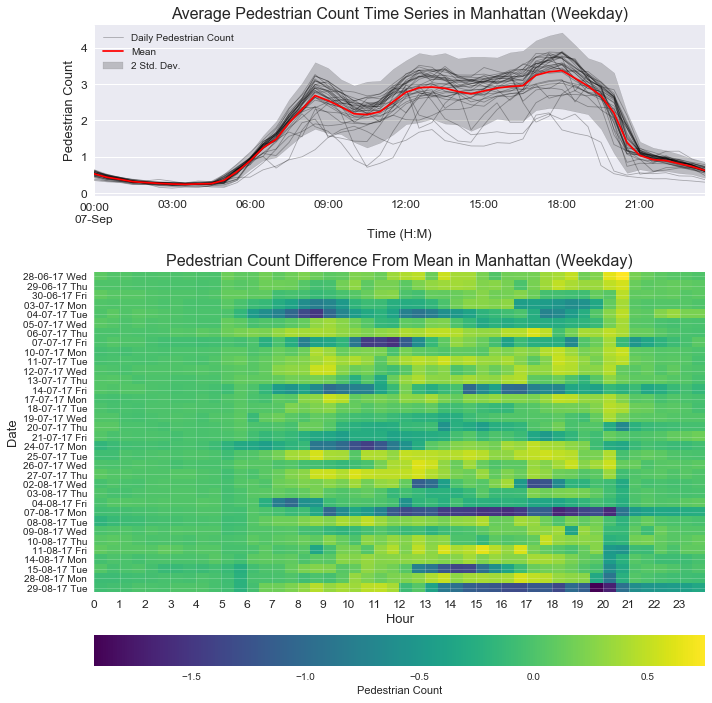

In [26]:
plot_cam_anoms(df[(df.boro == "Manhattan") & (df.people == 1.)],
               titles=("Average Pedestrian Count Time Series in Manhattan (Weekday)",
                       "Pedestrian Count Difference From Mean in Manhattan (Weekday)"))

### Weekend

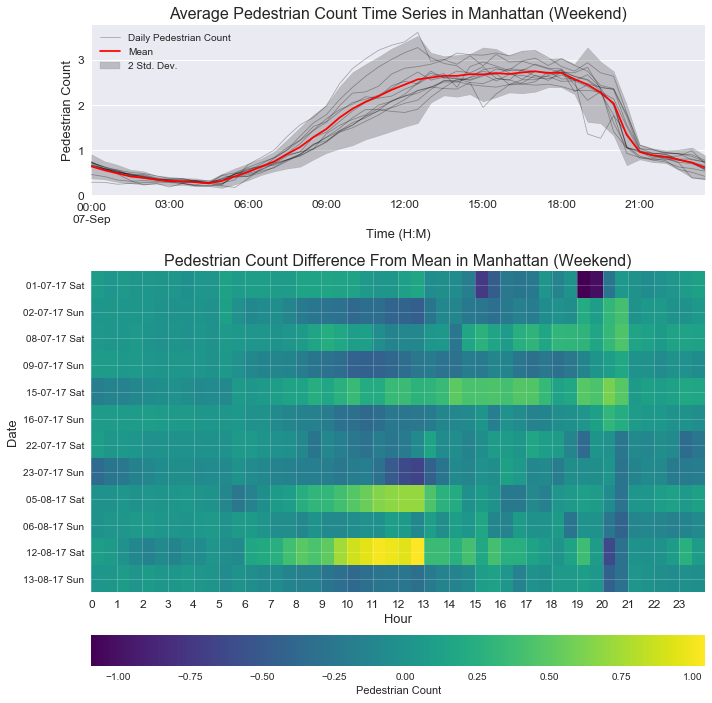

In [27]:
plot_cam_anoms(df[(df.boro == "Manhattan") & (df.people == 1.)],
               titles=("Average Pedestrian Count Time Series in Manhattan (Weekend)",
                       "Pedestrian Count Difference From Mean in Manhattan (Weekend)"),
               weekday=False)

## Brooklyn
### Weekday

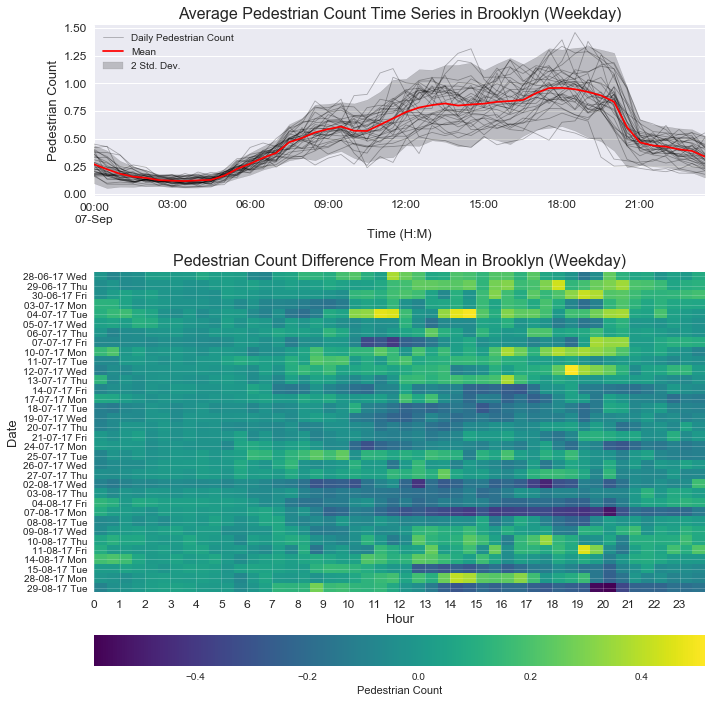

In [28]:
plot_cam_anoms(df[(df.boro == "Brooklyn") & (df.people == 1.)],
               titles=("Average Pedestrian Count Time Series in Brooklyn (Weekday)",
                       "Pedestrian Count Difference From Mean in Brooklyn (Weekday)"))

### Weekend

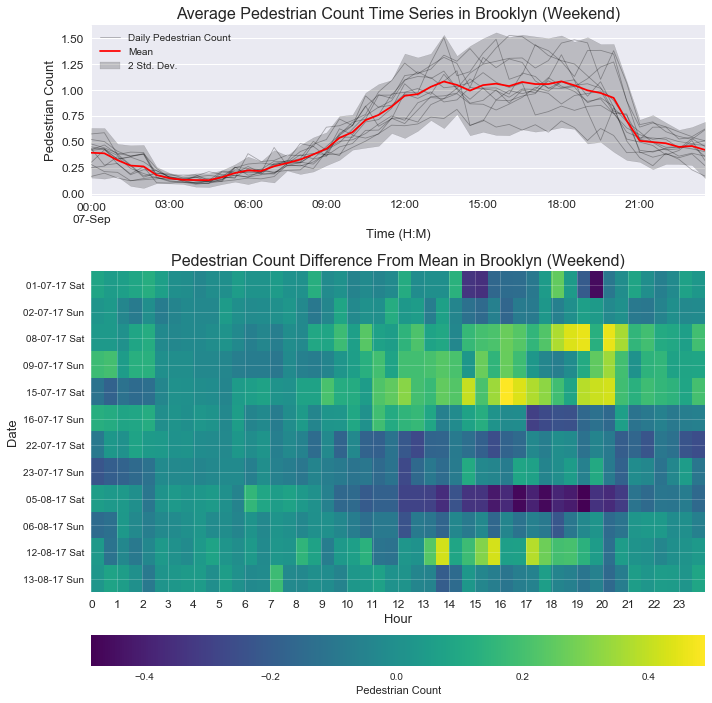

In [29]:
plot_cam_anoms(df[(df.boro == "Brooklyn") & (df.people == 1.)],
               titles=("Average Pedestrian Count Time Series in Brooklyn (Weekend)",
                       "Pedestrian Count Difference From Mean in Brooklyn (Weekend)"),
               weekday=False)

## Bronx

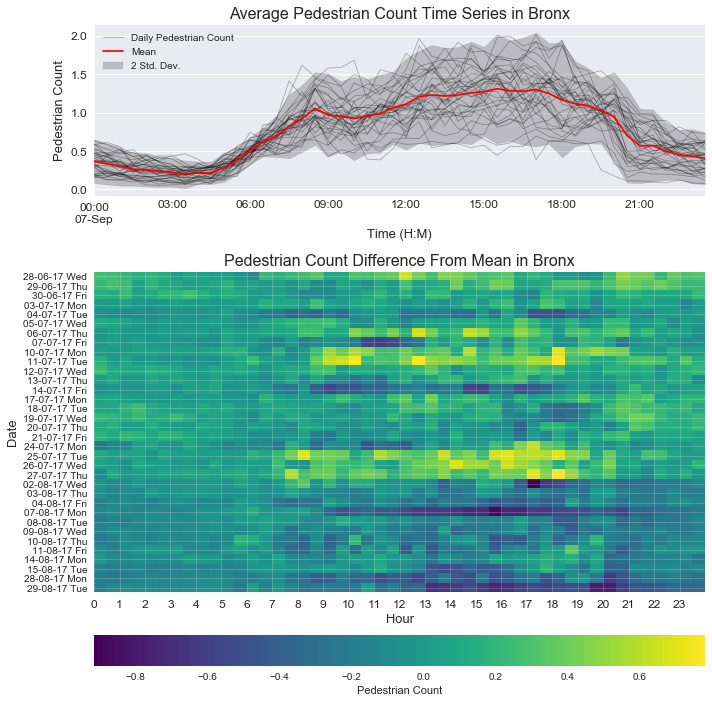

In [20]:
plot_cam_anoms(df[(df.boro == "Bronx") & (df.people == 1.)],
               titles=("Average Pedestrian Count Time Series in Bronx",
                       "Pedestrian Count Difference From Mean in Bronx"))

## Queens

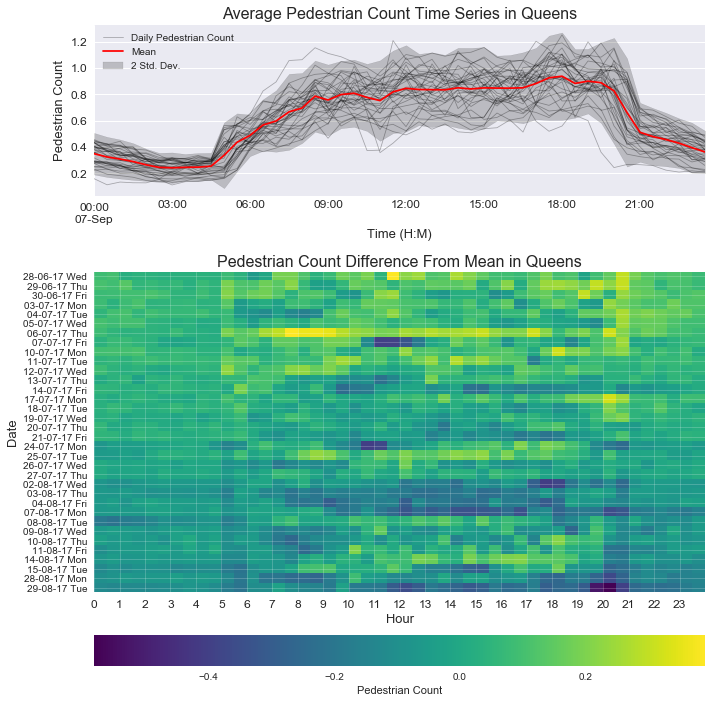

In [21]:
plot_cam_anoms(df[(df.boro == "Queens") & (df.people == 1.)],
               titles=("Average Pedestrian Count Time Series in Queens",
                       "Pedestrian Count Difference From Mean in Queens"))

## Staten Island

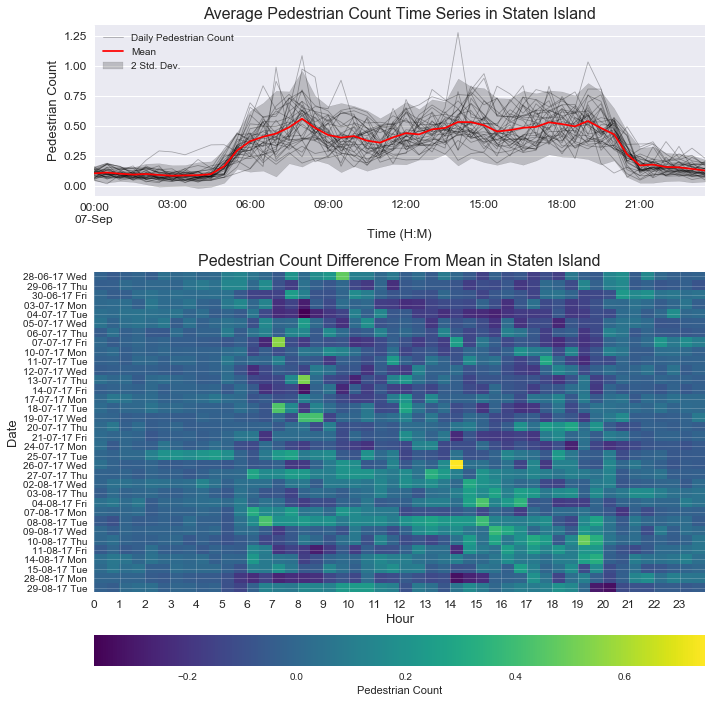

In [22]:
plot_cam_anoms(df[(df.boro == "Staten Island") & (df.people == 1.)],
               titles=("Average Pedestrian Count Time Series in Staten Island",
                       "Pedestrian Count Difference From Mean in Staten Island"))